# Online Retail Clustering

In [26]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Step 1: loading & preprocessing data

In [27]:
data = pd.read_csv("data/OnlineRetail.csv", encoding='unicode_escape')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [29]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.reset_index()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
401599,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
401600,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
401601,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
401602,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


### Step 2: Feature Engineering

RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:

- Recency (R): This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.
- Frequency (F): This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.
- Monetary (M): This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.
Together, these metrics help in understanding a customer's buying behavior and preferences, which is pivotal in personalizing marketing strategies and creating a recommendation system.

In [30]:
data["date"]=pd.to_datetime(data["InvoiceDate"], format="%d-%m-%Y %H:%M")
data.groupby("CustomerID")["date"].max()
max_date = data["date"].max()
recency = (max_date - data.groupby("CustomerID")["date"].max()).dt.days
recency = pd.DataFrame(recency)
recency.columns = ["Diff_date"]
recency

,Diff_date
CustomerID,
12346.0,325
12347.0,1
12348.0,74
12349.0,18
12350.0,309
...,...
18280.0,277
18281.0,180
18282.0,7


In [31]:
frequency = pd.DataFrame(data.groupby("CustomerID")["InvoiceNo"].count())
frequency.columns = ["Frequency"]
frequency

,Frequency
CustomerID,
12346.0,2
12347.0,182
12348.0,31
12349.0,73
12350.0,17
...,...
18280.0,10
18281.0,7
18282.0,13


In [32]:
data["amount"] = data["Quantity"] * data["UnitPrice"]
monetary = pd.DataFrame(data.groupby("CustomerID")["amount"].sum())
monetary

,amount
CustomerID,
12346.0,0.00
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40
...,...
18280.0,180.60
18281.0,80.82
18282.0,176.60


In [33]:
df = pd.merge(pd.merge(recency, frequency, on= "CustomerID", how="inner"), monetary, on="CustomerID", how="inner")
df

,Diff_date,Frequency,amount
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40
...,...,...,...
18280.0,277,10,180.60
18281.0,180,7,80.82
18282.0,7,13,176.60


### Step 3: Outlier Removal

{'whiskers': [<matplotlib.lines.Line2D at 0x24197619150>,
 'caps': [<matplotlib.lines.Line2D at 0x2419761a390>,
 'boxes': [<matplotlib.lines.Line2D at 0x24197618810>],
 'medians': [<matplotlib.lines.Line2D at 0x2419761b550>],
 'fliers': [<matplotlib.lines.Line2D at 0x2419761a090>],
 'means': []}

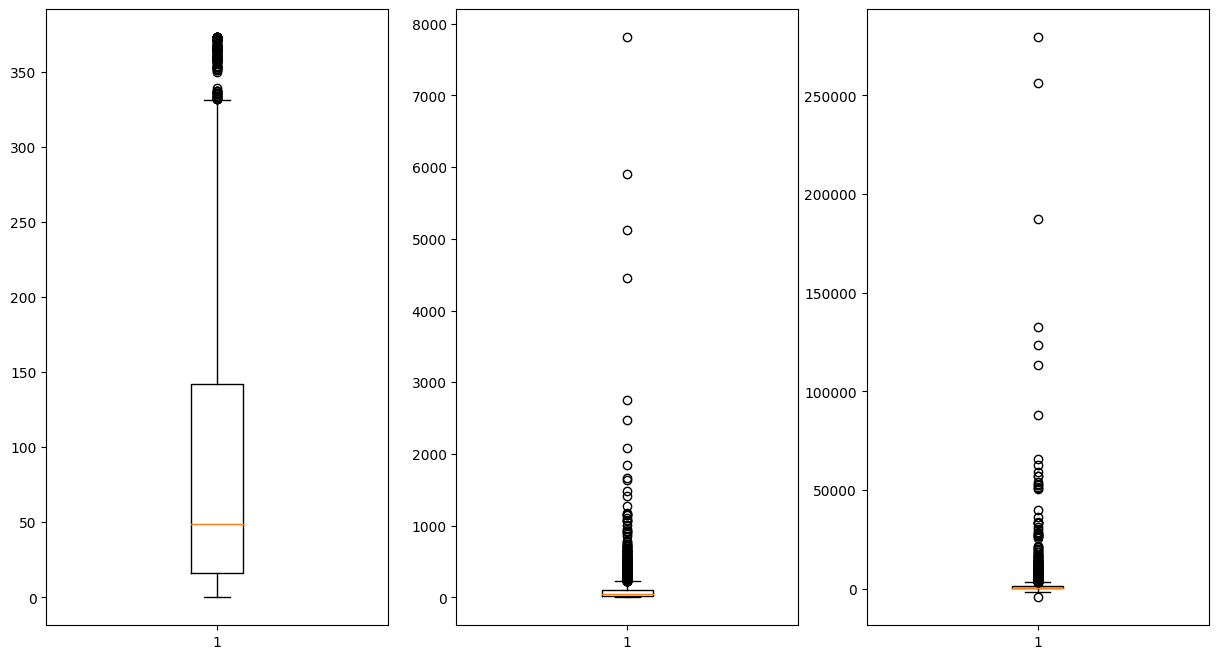

In [34]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.boxplot(df["Diff_date"])
plt.subplot(1,3,2)
plt.boxplot(df["Frequency"])
plt.subplot(1,3,3)
plt.boxplot(df["amount"])

In [35]:
Q1 = df["amount"].quantile(0.25)
Q3 = df["amount"].quantile(0.75)
IQR = Q3 - Q1 
df = df[(df["amount"]>= Q1 - 1.5*IQR) & ((df["amount"]<= Q3 + 1.5*IQR))]

Q1 = df["Diff_date"].quantile(0.25)
Q3 = df["Diff_date"].quantile(0.75)
IQR = Q3 - Q1 
df = df[(df["Diff_date"]>= Q1 - 1.5*IQR) & ((df["Diff_date"]<= Q3 + 1.5*IQR))]

Q1 = df["Frequency"].quantile(0.25)
Q3 = df["Frequency"].quantile(0.75)
IQR = Q3 - Q1 
df = df[(df["Frequency"]>= Q1 - 1.5*IQR) & ((df["Frequency"]<= Q3 + 1.5*IQR))]

df


,Diff_date,Frequency,amount
CustomerID,,,
12346.0,325,2,0.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40
12352.0,35,95,1545.41
...,...,...,...
18278.0,73,9,173.90
18280.0,277,10,180.60
18281.0,180,7,80.82


### Step 4: Scaling

In [36]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
cleaned = pd.DataFrame(scaled)
cleaned.columns = ["recency", "Frequency", "Amount"]
cleaned

,recency,Frequency,Amount
0,2.357576,-1.080968,-1.055105
1,-0.237666,-0.387136,1.366034
2,-0.816684,0.617723,1.312566
3,2.192143,-0.722089,-0.604621
4,-0.640910,1.144078,1.026783
...,...,...,...
3623,-0.248005,-0.913491,-0.820837
3624,1.861275,-0.889566,-0.811811
3625,0.858333,-0.961341,-0.946229
3626,-0.930420,-0.817790,-0.817200


### Step 5: clustering

In [37]:
kmeans = KMeans(n_clusters= 3)
kmeans.fit_predict(cleaned)
cleaned["cluster_id"] = kmeans.labels_
cleaned


c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,recency,Frequency,Amount,cluster_id
0,2.357576,-1.080968,-1.055105,1
1,-0.237666,-0.387136,1.366034,0
2,-0.816684,0.617723,1.312566,2
3,2.192143,-0.722089,-0.604621,1
4,-0.640910,1.144078,1.026783,2
...,...,...,...,...
3623,-0.248005,-0.913491,-0.820837,0
3624,1.861275,-0.889566,-0.811811,1
3625,0.858333,-0.961341,-0.946229,1
3626,-0.930420,-0.817790,-0.817200,0


### Step 6: Cluster Analysis

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='cluster_id', ylabel='Frequency'>

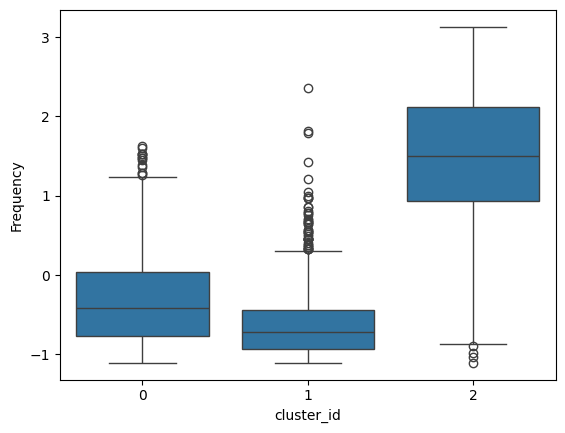

In [38]:
sns.boxplot(cleaned, x='cluster_id', y='Frequency')

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='cluster_id', ylabel='Amount'>

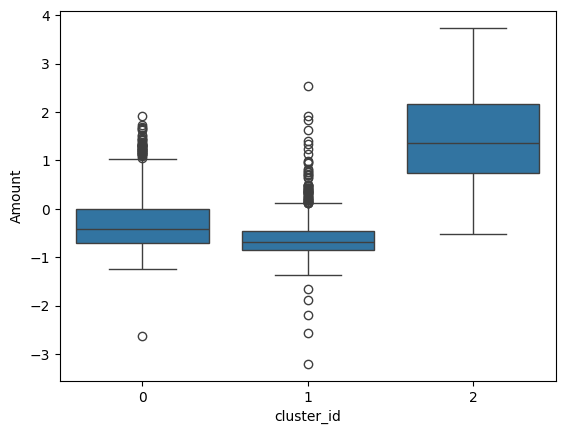

In [39]:
sns.boxplot(cleaned, x='cluster_id', y='Amount')

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='cluster_id', ylabel='recency'>

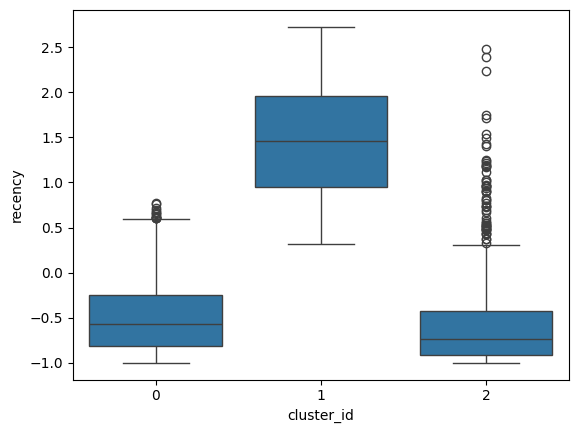

In [40]:
sns.boxplot(cleaned, x='cluster_id', y='recency')

### Cluster Analysis

- Customers with Cluster Id 1 are the frequent buyers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.